### Problem statement: 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Defining the path for train and test images
train_data = pathlib.Path("/content/gdrive/MyDrive/Melonama/Train")
test_data = pathlib.Path("/content/gdrive/MyDrive/Melonama/Test")

In [4]:
image_count_train = len(list(train_data.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(test_data.glob('*/*.jpg')))
print(image_count_test)

2250
118


**Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

Dataset Creation

Defining some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2250 files belonging to 9 classes.
Using 1800 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2250 files belonging to 9 classes.
Using 450 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Visualize the data**

Todo, create a code to visualize one instance of all the nine classes present in the dataset

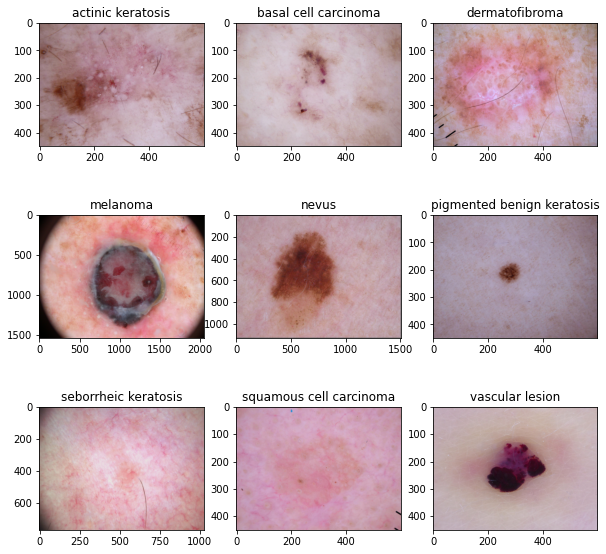

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(train_data.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Create the model**

Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [11]:
### Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

**Compile the model**

Choose an appropirate optimiser and loss function for model training

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Model summary**

View all the layers of the network using the Keras Model.summary method:

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


57/57 [==============================] - 155s 557ms/step - loss: 2.1195 - accuracy: 0.1844 - val_loss: 2.0816 - val_accuracy: 0.1867
Epoch 2/20
57/57 [==============================] - 4s 76ms/step - loss: 2.0212 - accuracy: 0.2044 - val_loss: 2.0010 - val_accuracy: 0.2311
Epoch 3/20
57/57 [==============================] - 4s 75ms/step - loss: 1.9833 - accuracy: 0.2222 - val_loss: 1.9534 - val_accuracy: 0.2489
Epoch 4/20
57/57 [==============================] - 4s 76ms/step - loss: 1.9530 - accuracy: 0.2361 - val_loss: 1.9716 - val_accuracy: 0.2489
Epoch 5/20
57/57 [==============================] - 4s 75ms/step - loss: 1.9728 - accuracy: 0.2256 - val_loss: 1.9832 - val_accuracy: 0.2489
Epoch 6/20
57/57 [==============================] - 4s 75ms/step - loss: 1.9734 - accuracy: 0.2261 - val_loss: 1.9634 - val_accuracy: 0.2400
Epoch 7/20
57/57 [==============================] - 4s 75ms/step - loss: 1.9372 - accuracy: 0.2522 - val_loss: 1.9587 - val_accuracy: 0.2600
Epoch 8/20
57/57 [===

**Visualizing training results**

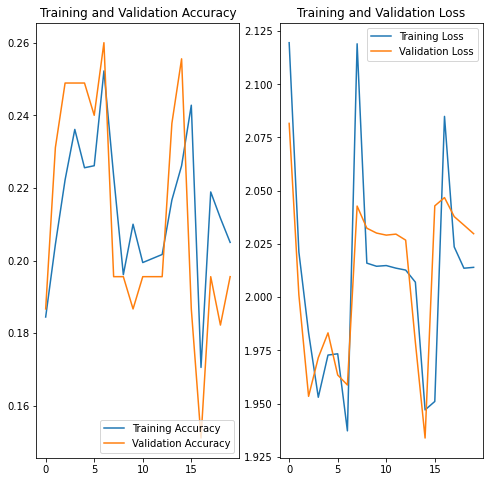

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

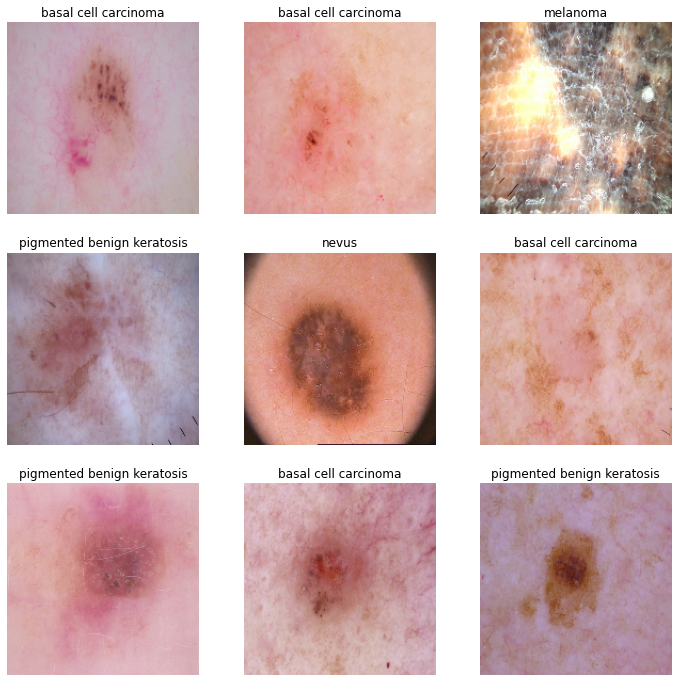

In [17]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [18]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


**Compiling the Code**

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 7s 91ms/step - loss: 2.0653 - accuracy: 0.1917 - val_loss: 1.9665 - val_accuracy: 0.2044
Epoch 2/20
57/57 [==============================] - 5s 85ms/step - loss: 1.9046 - accuracy: 0.2783 - val_loss: 1.9120 - val_accuracy: 0.2667
Epoch 3/20
57/57 [==============================] - 5s 85ms/step - loss: 1.8458 - accuracy: 0.3161 - val_loss: 1.8153 - val_accuracy: 0.2956
Epoch 4/20
57/57 [==============================] - 5s 85ms/step - loss: 1.6755 - accuracy: 0.3867 - val_loss: 1.6988 - val_accuracy: 0.3689
Epoch 5/20
57/57 [==============================] - 5s 85ms/step - loss: 1.6320 - accuracy: 0.4156 - val_loss: 1.6212 - val_accuracy: 0.4022
Epoch 6/20
57/57 [==============================] - 5s 85ms/step - loss: 1.6068 - accuracy: 0.4161 - val_loss: 1.7394 - val_accuracy: 0.3222
Epoch 7/20
57/57 [==============================] - 5s 85ms/step - loss: 1.6021 - accuracy: 0.4311 - val_loss: 1.6454 - val_accuracy: 0.4133
Epoch 8/20
57

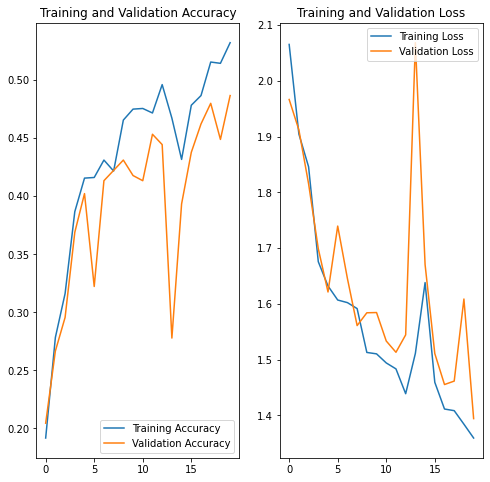

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
path=[]
lession_list=[]
for i in class_names:
      
    for j in train_data.glob(i+'/*.jpg'):
        path.append(str(j))
        lession_list.append(i)
df_dict_original = dict(zip(path, lession_list))
original_df = pd.DataFrame(list(df_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Melonama/Train/actinic...,actinic keratosis
1,/content/gdrive/MyDrive/Melonama/Train/actinic...,actinic keratosis
2,/content/gdrive/MyDrive/Melonama/Train/actinic...,actinic keratosis
3,/content/gdrive/MyDrive/Melonama/Train/actinic...,actinic keratosis
4,/content/gdrive/MyDrive/Melonama/Train/actinic...,actinic keratosis
...,...,...
2245,/content/gdrive/MyDrive/Melonama/Train/vascula...,vascular lesion
2246,/content/gdrive/MyDrive/Melonama/Train/vascula...,vascular lesion
2247,/content/gdrive/MyDrive/Melonama/Train/vascula...,vascular lesion
2248,/content/gdrive/MyDrive/Melonama/Train/vascula...,vascular lesion


In [23]:
df_dict_original = dict(zip(path, lession_list))
original_df = pd.DataFrame(list(df_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Melonama/Train/actinic...,actinic keratosis
1,/content/gdrive/MyDrive/Melonama/Train/actinic...,actinic keratosis
2,/content/gdrive/MyDrive/Melonama/Train/actinic...,actinic keratosis
3,/content/gdrive/MyDrive/Melonama/Train/actinic...,actinic keratosis
4,/content/gdrive/MyDrive/Melonama/Train/actinic...,actinic keratosis
...,...,...
2245,/content/gdrive/MyDrive/Melonama/Train/vascula...,vascular lesion
2246,/content/gdrive/MyDrive/Melonama/Train/vascula...,vascular lesion
2247,/content/gdrive/MyDrive/Melonama/Train/vascula...,vascular lesion
2248,/content/gdrive/MyDrive/Melonama/Train/vascula...,vascular lesion


<BarContainer object of 9 artists>

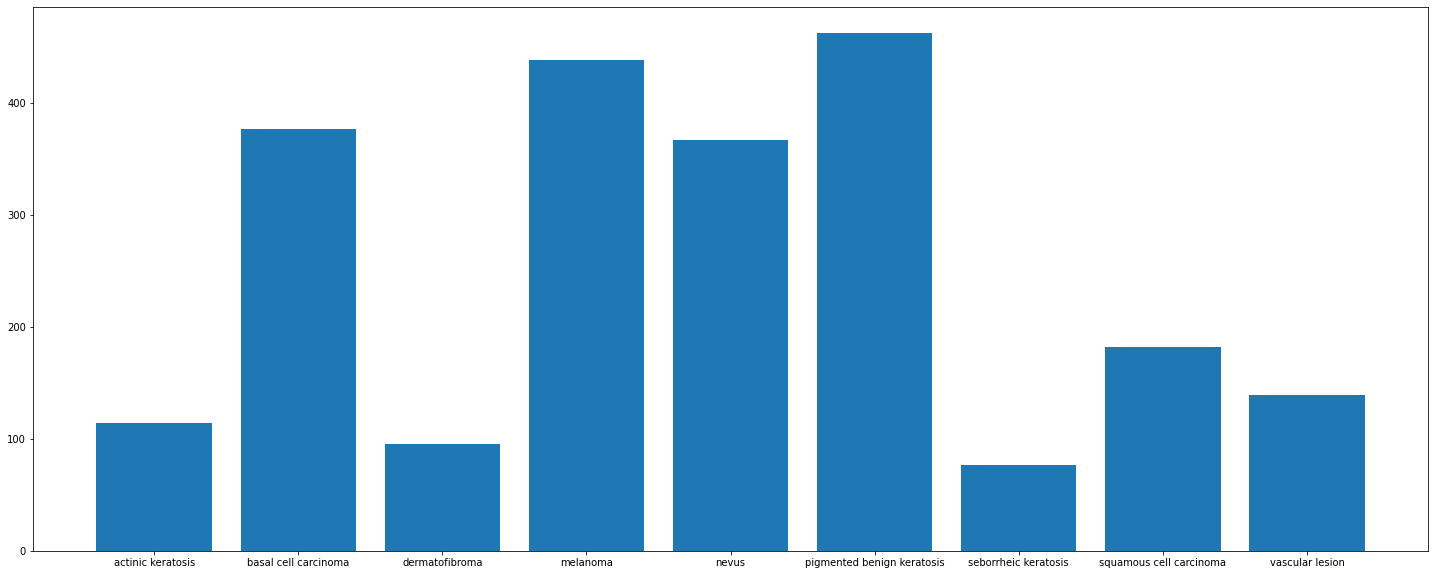

In [27]:
count=[]
for i in class_names:
    count.append(len(list(train_data.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

1.   quamous cell carcinoma has least number of samples
2.   actinic keratosis and dermatofibroma have proportionate number of classes. melanoma and pigmented benign keratosis have proprtionate number of classes

In [28]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [29]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline("/content/gdrive/MyDrive/Melonama/Train",save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2250 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melonama/Train/output.

Processing <PIL.Image.Image image mode=RGB size=960x724 at 0x7FF057E48750>: 100%|██████████| 500/500 [00:41<00:00, 11.92 Samples/s]


Initialised with 2250 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melonama/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF05A0BFF10>: 100%|██████████| 500/500 [00:41<00:00, 12.11 Samples/s]


Initialised with 2250 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melonama/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF0568CFB90>: 100%|██████████| 500/500 [00:41<00:00, 12.01 Samples/s]


Initialised with 2250 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melonama/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7FF072223050>: 100%|██████████| 500/500 [00:37<00:00, 13.25 Samples/s]


Initialised with 2250 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melonama/Train/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FF056975450>: 100%|██████████| 500/500 [00:42<00:00, 11.75 Samples/s]


Initialised with 2250 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melonama/Train/output.

Processing <PIL.Image.Image image mode=RGB size=796x682 at 0x7FF0E056F710>: 100%|██████████| 500/500 [00:42<00:00, 11.68 Samples/s]


Initialised with 2250 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melonama/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF057E1D410>: 100%|██████████| 500/500 [00:46<00:00, 10.81 Samples/s]


Initialised with 2250 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melonama/Train/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FF07205ACD0>: 100%|██████████| 500/500 [00:37<00:00, 13.16 Samples/s]


Initialised with 2250 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melonama/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF056653E50>: 100%|██████████| 500/500 [00:45<00:00, 10.97 Samples/s]


In [40]:
image_count_train = len(list(train_data.glob('*/output/*.jpg')))
print(image_count_train)

0


Lets see the distribution of augmented data after adding new images to the original training data.


In [43]:
from glob import *
path_list = [x for x in glob(os.path.join(train_data, '*','output', '*.jpg'))]
path_list

[]

In [45]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(train_data, '*','output', '*.jpg'))]
lesion_list_new

[]

In [47]:
df_dict_new = dict(zip(path_list, lesion_list_new))


In [49]:
df2 = pd.DataFrame(list(df_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [50]:
new_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         367
squamous cell carcinoma       182
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

**NOW**

Train the model on the data created using Augmentor

In [51]:
batch_size = 32
img_height = 180
img_width = 180

Create a Training dataset:

In [56]:
data_dir_train="/content/gdrive/MyDrive/Melonama/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size = (img_height, img_width),
  batch_size=batch_size)

Found 11250 files belonging to 10 classes.
Using 9000 files for training.


Create a validation dataset

In [57]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11250 files belonging to 10 classes.
Using 2250 files for validation.


Training the Model

In [58]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

Compile the Model

In [59]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training the Model:

In [61]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


282/282 [==============================] - 55s 188ms/step - loss: nan - accuracy: 0.0093 - val_loss: nan - val_accuracy: 0.0129
Epoch 2/30
282/282 [==============================] - 54s 189ms/step - loss: nan - accuracy: 0.0094 - val_loss: nan - val_accuracy: 0.0129
Epoch 3/30
282/282 [==============================] - 53s 183ms/step - loss: nan - accuracy: 0.0094 - val_loss: nan - val_accuracy: 0.0129
Epoch 4/30
282/282 [==============================] - 53s 183ms/step - loss: nan - accuracy: 0.0094 - val_loss: nan - val_accuracy: 0.0129
Epoch 5/30
282/282 [==============================] - 53s 184ms/step - loss: nan - accuracy: 0.0094 - val_loss: nan - val_accuracy: 0.0129
Epoch 6/30
282/282 [==============================] - 53s 183ms/step - loss: nan - accuracy: 0.0094 - val_loss: nan - val_accuracy: 0.0129
Epoch 7/30
282/282 [==============================] - 52s 179ms/step - loss: nan - accuracy: 0.0094 - val_loss: nan - val_accuracy: 0.0129
Epoch 8/30
282/282 [==================

Visualize the model results

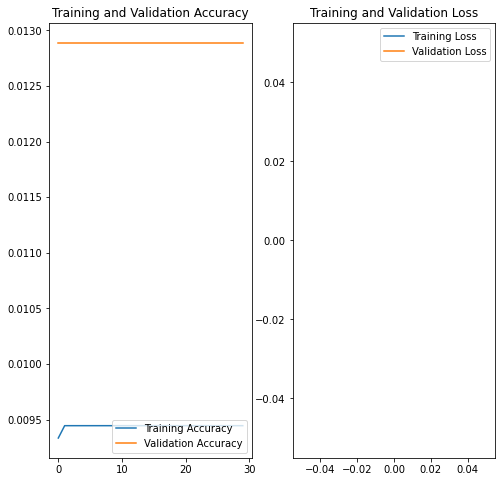

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()